## IMPORT

In [1]:
import tarfile
import shutil
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import yaml
import os, torch
from pathlib import Path
from torchvision.ops import box_iou
import warnings
import sys, time, warnings, subprocess
from kaggle_secrets import UserSecretsClient
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import models
from torchvision import transforms as T
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.notebook import tqdm  # se sei in notebook Jupyter/Kaggle
from typing import Optional
warnings.filterwarnings("ignore")

## SETUP ENVIRONMENT

In [2]:
!gdown --folder https://drive.google.com/drive/u/1/folders/1Qirh0lsjdsroLHEmJDtS6sVXPQKalW6j -O datasets

Retrieving folder contents
Processing file 1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X ccpd_test.tar
Processing file 1RGEnfa5xWhDzO6oSoECQwQwyP4BRH5d_ ccpd_train.tar
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X
From (redirected): https://drive.google.com/uc?id=1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X&confirm=t&uuid=0ce11aab-5040-47bf-a13c-47a22d613c11
To: /kaggle/working/datasets/ccpd_test.tar
100%|████████████████████████████████████████| 557M/557M [00:09<00:00, 60.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1RGEnfa5xWhDzO6oSoECQwQwyP4BRH5d_
From (redirected): https://drive.google.com/uc?id=1RGEnfa5xWhDzO6oSoECQwQwyP4BRH5d_&confirm=t&uuid=7b7e3d90-2079-48e0-ab84-a07505c1f213
To: /kaggle/working/datasets/ccpd_train.tar
100%|███████████████████████████████████████| 3.76G/3.76G [00:33<00:00, 112MB/s]
Download completed


In [3]:
# extracting the .tar archive.
def extract_tar_archive(archive_path, destination_path):

    print(f"Extracting the tar archive in:{archive_path}")
    with tarfile.open(archive_path, "r") as tar:
        tar.extractall(path=destination_path)
        
    print(f"Archive extracted in: {destination_path}")

#delete the .tar archive which now is useless.
def delete_tar_archive(path_tar_archive):
    
    if os.path.exists(path_tar_archive):
        shutil.rmtree(path_tar_archive)
        print(f"Folder eliminated: {path_tar_archive}")
    else:
        print(f"Folder not found: {path_tar_archive}")

In [4]:
archive_path_train = "/kaggle/working/datasets/ccpd_train.tar"
archive_path_test = "/kaggle/working/datasets/ccpd_test.tar"
extract_path = "/kaggle/working/"

#when extracting the files, is important to eliminate the .tar archive which now occupy /kaggle/working space.
extract_tar_archive(archive_path_train, extract_path)
extract_tar_archive(archive_path_test, extract_path)
delete_tar_archive("/kaggle/working/datasets/")

Extracting the tar archive in:/kaggle/working/datasets/ccpd_train.tar
Archive extracted in: /kaggle/working/
Extracting the tar archive in:/kaggle/working/datasets/ccpd_test.tar
Archive extracted in: /kaggle/working/
Folder eliminated: /kaggle/working/datasets/


## GLOBAL

In [5]:
PROVINCES = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑",
             "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤",
             "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁",
             "新", "警", "学", "O"]

ALPHA = ['A','B','C','D','E','F','G','H','J','K',
             'L','M','N','P','Q','R','S','T','U','V',
             'W','X','Y','Z','O'] 

ADS = ['A','B','C','D','E','F','G','H','J','K',
       'L','M','N','P','Q','R','S','T','U','V',
       'W','X','Y','Z','0','1','2','3','4','5',
       '6','7','8','9','O']

## FUNCTION

In [6]:
#extracting the metadata from each img in this format (image_path,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number)
def decode_plate(s):
    "this method is used for decoding the plate starting from the name of .jpg file"
    idx   = list(map(int, s.split("_")))
    try:
        return PROVINCES[idx[0]] + ALPHA[idx[1]] + "".join(ADS[i] for i in idx[2:])
    except Exception:
        return None


def split_bbox(bbox_str):
    "extracting x1,y1,x2,y2, ex. '283___502_511___591'  →  ['283','502','511','591']"
    tokens = []
    for seg in bbox_str.split("___"):
        tokens.extend(seg.split("_"))
    if len(tokens) == 4 and all(t.isdigit() for t in tokens):
        return map(int, tokens)
    return (None,)*4

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Totale parametri:     {total:,}")
    print(f"Parametri addestrabili: {trainable:,}")

In [7]:
folder = "/kaggle/working/ccpd_subset_base/train"
rows   = []

for fname in os.listdir(folder):
    if not fname.endswith(".jpg"): continue

    parts = fname[:-4].split("-")           
    if len(parts) < 6:
        continue #the ccpd file name is wrong           

    x1,y1,x2,y2 = split_bbox(parts[2])      
    plate = decode_plate(parts[4])    

    rows.append({
        "image_path": os.path.join(folder, fname),
        "x1_bbox": x1, "y1_bbox": y1,
        "x2_bbox": x2, "y2_bbox": y2,
        "plate_number": plate
    })

df = pd.DataFrame(rows)
print("Rows number:", len(df))         
print("Columns numner:", df.shape[1])
print("Shape:", df.shape)
df.head()

Rows number: 50000
Columns numner: 6
Shape: (50000, 6)


,image_path,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number
0,/kaggle/working/ccpd_subset_base/train/0104166...,223,549,412,616,粤S7HP91
1,/kaggle/working/ccpd_subset_base/train/0153292...,234,505,489,572,皖AWV802
2,/kaggle/working/ccpd_subset_base/train/0134482...,280,501,508,566,皖AKM178
3,/kaggle/working/ccpd_subset_base/train/0247198...,106,600,342,714,皖A8N817
4,/kaggle/working/ccpd_subset_base/train/0104525...,302,484,498,555,皖ACS122


In [8]:
#we split the dataset in 80/20 for training phase.
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

print(f"Train set: {len(df_train)} img")
print(f"Val set:   {len(df_val)} img")

Train set: 40000 img
Val set:   10000 img


## MODEL ARCHITECTURE

In [9]:
# lp_detector.py
"""Simple licence‑plate bounding‑box detector

Questo modulo implementa un modello PyTorch che prende un'immagine intera
(B, 3, H, W) e restituisce 4 coordinate normalizzate (cx, cy, w, h) della targa.

Punti chiave:
- Backbone sostituibile (ResNet18 default, EfficientNet‑B0 opzionale)
- Pesi ImageNet per avviare il training già con feature robuste
- AdattiveAvgPool2d → MLP → Sigmoid per avere output in [0,1]
- Loss suggerita: IoU o Smooth‑L1 sulle box denormalizzate

Uso rapido:

    >>> import torch
    >>> from lp_detector import LPDetector
    >>> model = LPDetector(backbone_name="resnet18", pretrained=True)
    >>> x = torch.randn(4, 3, 480, 480)
    >>> bbox = model(x)  # shape (4,4)
    >>> print(bbox[0])   # tensor([cx, cy, w, h])

"""
from typing import Tuple

import torch
import torch.nn as nn
import torchvision.models as tvm

__all__ = ["LPDetector"]


class LPDetector(nn.Module):
    """Licence‑plate detector with pluggable backbone.

    Parameters
    ----------
    backbone_name : str
        Nome del backbone torchvision ("resnet18" | "efficientnet_b0").
    pretrained : bool
        Se True usa pesi pre‑addestrati su ImageNet.
    head_hidden : int
        Dimensione dello strato hidden dell'MLP.
    """

    def __init__(
        self,
        backbone_name: str = "resnet18",
        pretrained: bool = True,
        head_hidden: int = 256,
    ) -> None:
        super().__init__()

        self.backbone, feat_channels = self._build_backbone(
            backbone_name, pretrained
        )

        if "resnet" in backbone_name:
            for name, param in self.backbone.named_parameters():
                if any(name.startswith(l) for l in ["0", "1", "4", "5"]):  # conv1, bn1, layer1, layer2
                    param.requires_grad = False

        # Head: Global pooling → MLP → bbox (cx, cy, w, h) in [0,1]
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_channels, head_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(head_hidden, 4),
            nn.Sigmoid(),  # keeps output in [0,1]
        )

    @staticmethod
    def _build_backbone(
        name: str, pretrained: bool = True
    ) -> Tuple[nn.Sequential, int]:
        """Restituisce (feature_extractor, num_channels)."""

        if name == "resnet18":
            m = tvm.resnet18(weights=tvm.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
            # rimuoviamo avgpool & fc, teniamo features fino a layer4
            layers = list(m.children())[:-2]
            feat_channels = 512
            backbone = nn.Sequential(*layers)
        elif name == "efficientnet_b0":
            m = tvm.efficientnet_b0(
                weights=tvm.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
            )
            backbone = m.features  # output: B×1280×7×7 su input 224×224
            feat_channels = 1280
        else:
            raise ValueError(f"Backbone {name!r} non supportato")

        return backbone, feat_channels

    # ---------------------------------------------------------
    # forward
    # ---------------------------------------------------------
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # B×3×H×W → B×4
        feat = self.backbone(x)        # feature map
        pooled = self.pool(feat)       # B×C×1×1
        bbox = self.regressor(pooled)  # B×4 normalizzato 0‑1
        return bbox

## TRAIN PHASE

In [10]:
import pandas as pd, numpy as np, torch
from PIL import Image
from pathlib import Path
from tqdm import tqdm

def preprocess_resize_bbox(df: pd.DataFrame,
                           out_dir: str = "preproc224",
                           img_size: int = 224,
                           save_as_pt: bool = False,
                           quality: int = 95) -> pd.DataFrame:
    """
    • df   : DataFrame con colonne image_path, x1_bbox, y1_bbox, x2_bbox, y2_bbox
    • out_dir: cartella dove salvare le immagini ridotte
    • img_size: lato desiderato (quadrato)
    • save_as_pt: True → salva tensor .pt; False → JPEG
    • quality   : qualità JPEG (solo se save_as_pt=False)
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    records = []
    to_tensor = torch.from_numpy   # scorciatoia

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Pre‑resize"):
        img = Image.open(row.image_path).convert("RGB")
        w0, h0 = img.size

        # Ridimensiona mantenendo la distorsione esattamente come Resize((224,224))
        img = img.resize((img_size, img_size), Image.BILINEAR)

        # Fattore di scala per bbox
        sx, sy = img_size / w0, img_size / h0
        x1 = row.x1_bbox * sx
        y1 = row.y1_bbox * sy
        x2 = row.x2_bbox * sx
        y2 = row.y2_bbox * sy

        # Salva
        stem = Path(row.image_path).stem
        if save_as_pt:
            tensor = to_tensor(np.array(img)).permute(2, 0, 1).float() / 255
            path_out = out_dir / f"{stem}.pt"
            torch.save(tensor, path_out)
        else:
            path_out = out_dir / f"{stem}.jpg"
            img.save(path_out, format="JPEG", quality=quality, optimize=True)

        records.append({
            "image_path": str(path_out),
            "x1_bbox": x1, "y1_bbox": y1,
            "x2_bbox": x2, "y2_bbox": y2,
            **{c: row[c] for c in df.columns if c not in (
               "image_path","x1_bbox","y1_bbox","x2_bbox","y2_bbox")}
        })

    return pd.DataFrame.from_records(records)

In [21]:
# 1. Pre‑process una volta sola
df_train_224 = preprocess_resize_bbox(df_train, "train224", img_size=640, save_as_pt=False)
df_val_224   = preprocess_resize_bbox(df_val,   "val224",   img_size=640, save_as_pt=False)

Pre‑resize:   0%|          | 0/40000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2, torch
from torch.utils.data import Dataset

class PlateDatasetFastAug(Dataset):
    def __init__(self, df, augment=True, img_size=640):
        self.df = df.reset_index(drop=True)
        self.augment = augment
        self.img_size = img_size

        self.pipeline = A.Compose([
            A.OneOf([
                A.GaussianBlur(blur_limit=3, p=0.3),
                A.MotionBlur(blur_limit=5, p=0.2),
                A.GaussNoise(var_limit=(10, 50), p=0.3),
            ], p=0.4),
        
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
                A.RandomBrightnessContrast(brightness_limit=(-0.6, -0.3), contrast_limit=0.2, p=0.3),  # <<-- scurisce
            ], p=0.5),
        
            A.RandomGamma(gamma_limit=(80, 120), p=0.3),
            A.ColorJitter(0.2, 0.2, 0.2, 0.1, p=0.2),
        
            ToTensorV2()
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.cvtColor(cv2.imread(row.image_path), cv2.COLOR_BGR2RGB)

        transformed = self.pipeline(image=img)
        img_tensor = transformed["image"].float() / 255.0

        # normalizza bbox
        x1, y1, x2, y2 = row.x1_bbox, row.y1_bbox, row.x2_bbox, row.y2_bbox
        cx = (x1 + x2) / 2 / self.img_size
        cy = (y1 + y2) / 2 / self.img_size
        w  = (x2 - x1)      / self.img_size
        h  = (y2 - y1)      / self.img_size
        bbox = torch.tensor([cx, cy, w, h], dtype=torch.float32)

        return img_tensor, bbox


def create_data_loaders_fast(df_train, df_val=None,
                             *, batch_size=128, num_workers=8,
                             tensors=False):
    common = dict(
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )
    ds_train = PlateDatasetFast(df_train, tensors=tensors, augment=True)
    dl_train = DataLoader(ds_train, shuffle=True, **common)

    dl_val = None
    if df_val is not None and len(df_val):
        ds_val = PlateDatasetFast(df_val, tensors=tensors, augment=False)
        dl_val = DataLoader(ds_val, shuffle=False, **common)

    return dl_train, dl_val

In [13]:
def train_one_epoch(model: nn.Module, data_loader, optimizer, device: str, epoch: int = 0):
    model.train()
    criterion = nn.SmoothL1Loss()
    running = 0.0

    pbar = tqdm(data_loader, desc=f" Epoch {epoch}", leave=True)
    for batch_idx, (imgs, targets) in enumerate(pbar):
        imgs  = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        preds = model(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        running += batch_loss * imgs.size(0)
        pbar.set_postfix(loss=f"{batch_loss:.4f}")  

    return running / len(data_loader.dataset)

def evaluate(model: nn.Module, data_loader, device: str):
    model.eval()
    criterion = nn.SmoothL1Loss(reduction="sum")
    loss_sum = 0.0
    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            loss_sum += criterion(preds, targets).item()
    return loss_sum / len(data_loader.dataset)


def train(model: nn.Module, dl_train, dl_val, epochs: int, lr: float, device: str):
    model.to(device)
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4)
    for epoch in range(1, epochs + 1):
        print(f"\n Starting epoch {epoch}/{epochs}")
        loss_tr = train_one_epoch(model, dl_train, opt, device, epoch)
        msg = f" Epoch {epoch:02d}/{epochs} | train_loss: {loss_tr:.4f}"
        if dl_val is not None:
            loss_val = evaluate(model, dl_val, device)
            msg += f" | val_loss: {loss_val:.4f}"
        print(msg)

    return model

In [14]:
import matplotlib.pyplot as plt
import torchvision
import torch

def show_aug_examples(dataset, n=8):
    """Mostra n esempi casuali da un PlateDatasetFastAug"""
    model_mode = dataset.augment
    dataset.augment = True  # forza augmentation

    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    for ax in axes:
        idx = torch.randint(0, len(dataset), (1,)).item()
        img, bbox = dataset[idx]  # tensor 3×224×224, bbox normalized cxcywh
        img_np = (img.permute(1, 2, 0).numpy() * 255).astype("uint8")

        # converti bbox normalizzata a xyxy pixel
        cx, cy, w, h = bbox.numpy()
        cx *= 224; cy *= 224; w *= 224; h *= 224
        x1 = int(cx - w / 2); y1 = int(cy - h / 2)
        x2 = int(cx + w / 2); y2 = int(cy + h / 2)

        img_box = img_np.copy()
        img_box = cv2.rectangle(img_box, (x1, y1), (x2, y2), (255, 0, 0), 2)
        ax.imshow(img_box)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    dataset.augment = model_mode  # ripristina stato originale


In [15]:
train_ds = PlateDatasetFastAug(df_train_224, augment=True)

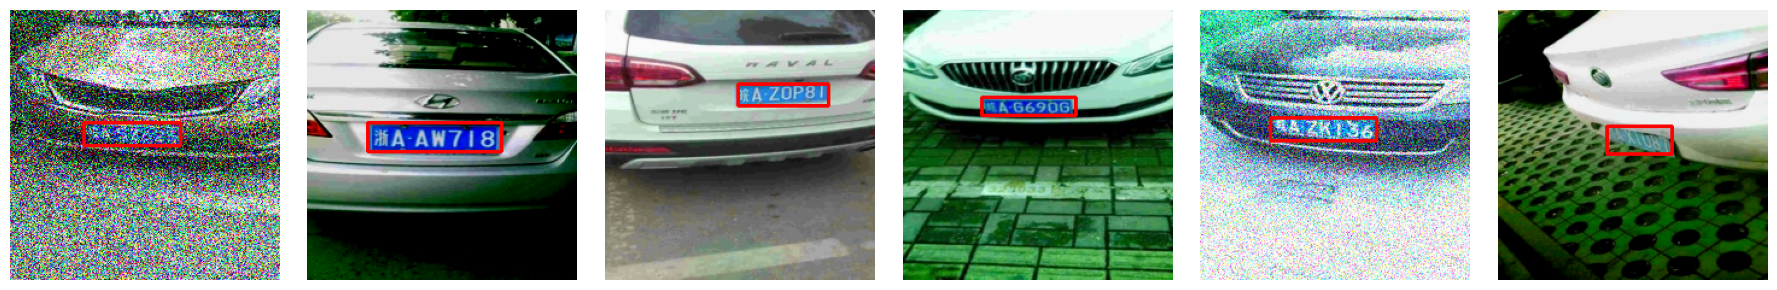

In [20]:
show_aug_examples(train_ds, n=6)

In [17]:
train_ds = PlateDatasetFastAug(df_train_224, augment=True)
val_ds   = PlateDatasetFastAug(df_val_224, augment=False)

dl_train = DataLoader(train_ds, batch_size=128, shuffle=True,
                      num_workers=8, pin_memory=True)
dl_val   = DataLoader(val_ds, batch_size=128, shuffle=False,
                      num_workers=4, pin_memory=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LPDetector().to(device)       
count_parameters(model)
model  = train(model, dl_train, dl_val,
               epochs=10, lr=1e-4, device=device)

torch.save(model.state_dict(), "/kaggle/working/lp2_detector.pt")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


Totale parametri:     11,308,868
Parametri addestrabili: 10,625,796

 Starting epoch 1/10


 Epoch 1: 100%|██████████| 313/313 [00:48<00:00,  6.45it/s, loss=0.0003]


 Epoch 01/10 | train_loss: 0.0009 | val_loss: 0.0010

 Starting epoch 2/10


 Epoch 2: 100%|██████████| 313/313 [00:47<00:00,  6.66it/s, loss=0.0002]


 Epoch 02/10 | train_loss: 0.0002 | val_loss: 0.0006

 Starting epoch 3/10


 Epoch 3: 100%|██████████| 313/313 [00:49<00:00,  6.36it/s, loss=0.0001]


 Epoch 03/10 | train_loss: 0.0001 | val_loss: 0.0005

 Starting epoch 4/10


 Epoch 4: 100%|██████████| 313/313 [00:46<00:00,  6.68it/s, loss=0.0001]


 Epoch 04/10 | train_loss: 0.0001 | val_loss: 0.0005

 Starting epoch 5/10


 Epoch 5: 100%|██████████| 313/313 [00:47<00:00,  6.63it/s, loss=0.0001]


 Epoch 05/10 | train_loss: 0.0001 | val_loss: 0.0004

 Starting epoch 6/10


 Epoch 6: 100%|██████████| 313/313 [00:48<00:00,  6.44it/s, loss=0.0001]


 Epoch 06/10 | train_loss: 0.0001 | val_loss: 0.0004

 Starting epoch 7/10


 Epoch 7: 100%|██████████| 313/313 [00:49<00:00,  6.29it/s, loss=0.0001]


 Epoch 07/10 | train_loss: 0.0001 | val_loss: 0.0004

 Starting epoch 8/10


 Epoch 8: 100%|██████████| 313/313 [00:49<00:00,  6.31it/s, loss=0.0001]


 Epoch 08/10 | train_loss: 0.0001 | val_loss: 0.0004

 Starting epoch 9/10


 Epoch 9: 100%|██████████| 313/313 [00:49<00:00,  6.39it/s, loss=0.0002]


 Epoch 09/10 | train_loss: 0.0001 | val_loss: 0.0004

 Starting epoch 10/10


 Epoch 10: 100%|██████████| 313/313 [00:49<00:00,  6.34it/s, loss=0.0002]


 Epoch 10/10 | train_loss: 0.0001 | val_loss: 0.0004


## TEST

In [18]:
from pathlib import Path
import pandas as pd
import os

root   = Path("/kaggle/working/ccpd_test")   # cartella principale
rows   = []

# scansione ricorsiva *.jpg
for jpg in root.rglob("*.jpg"):
    fname = jpg.name
    parts = fname[:-4].split("-")            # ccpd: A-B-C-D-E-F.jpg
    if len(parts) < 6:
        continue                            # file non conforme

    try:
        x1, y1, x2, y2 = split_bbox(parts[2])
        plate          = decode_plate(parts[4])
    except Exception as e:
        print("skip", jpg, e)
        continue

    rows.append({
        "subset": jpg.parent.name,          # <- nome cartella immediata
        "image_path": str(jpg),
        "x1_bbox": x1, "y1_bbox": y1,
        "x2_bbox": x2, "y2_bbox": y2,
        "plate_number": plate
    })

df = pd.DataFrame(rows)

print("Rows:",   len(df))
print("Cols:",   df.shape[1])
print("Shape:",  df.shape)
display(df.head())

Rows: 8000
Cols: 7
Shape: (8000, 7)


,subset,image_path,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number
0,tilt,/kaggle/working/ccpd_test/tilt/3299-19_16-84__...,84,297,719,731,皖A72W62
1,tilt,/kaggle/working/ccpd_test/tilt/0231-16_14-183_...,183,390,348,507,陕AC2L23
2,tilt,/kaggle/working/ccpd_test/tilt/0224-27_34-349_...,349,447,481,589,皖AH285V
3,tilt,/kaggle/working/ccpd_test/tilt/0295-27_21-303_...,303,451,457,611,皖AX8W51
4,tilt,/kaggle/working/ccpd_test/tilt/0621-38_46-241_...,241,390,437,655,皖A13017


In [19]:
import torch, torchvision.transforms as T
import pandas as pd, numpy as np, cv2, os
from pathlib import Path
from tqdm.auto import tqdm

# --------------------------------------------------
# 1. CARICA IL MODELLO ADDDESTRATO
# --------------------------------------------------
device   = "cuda" if torch.cuda.is_available() else "cpu"
detector = LPDetector()
detector.load_state_dict(
    torch.load("/kaggle/working/lp2_detector.pt", map_location=device)
)
detector.to(device).eval()

# --------------------------------------------------
# 2. FUNZIONE IoU E LOSS
# --------------------------------------------------
def bbox_iou(pred, tgt):
    """pred, tgt: cxcywh normalizzati ∈ [0,1] (stessa scala)."""
    px1 = pred[:, 0] - pred[:, 2] / 2
    py1 = pred[:, 1] - pred[:, 3] / 2
    px2 = pred[:, 0] + pred[:, 2] / 2
    py2 = pred[:, 1] + pred[:, 3] / 2

    tx1 = tgt[:, 0] - tgt[:, 2] / 2
    ty1 = tgt[:, 1] - tgt[:, 3] / 2
    tx2 = tgt[:, 0] + tgt[:, 2] / 2
    ty2 = tgt[:, 1] + tgt[:, 3] / 2

    inter_w = (torch.min(px2, tx2) - torch.max(px1, tx1)).clamp(min=0)
    inter_h = (torch.min(py2, ty2) - torch.max(py1, ty1)).clamp(min=0)
    inter   = inter_w * inter_h
    area_p  = (px2 - px1) * (py2 - py1)
    area_t  = (tx2 - tx1) * (ty2 - ty1)
    union   = area_p + area_t - inter + 1e-7
    return inter / union

smooth_l1 = torch.nn.SmoothL1Loss(reduction="mean")

# --------------------------------------------------
# 3. TRASFORMAZIONE IMMAGE → 224×224
# --------------------------------------------------
def tfm224(img_np):
    return T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224), interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor(),
    ])(img_np)

# --------------------------------------------------
# 4. VALUTA UN SINGOLO SUBSET
# --------------------------------------------------
@torch.no_grad()
def eval_subset(df_subset, name, iou_thr=0.6, img_size=224):
    ious, losses = [], []
    correct = 0
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset),
                       desc=f"{name:10}", leave=False):
        img_bgr = cv2.imread(row.image_path)
        if img_bgr is None:
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h0, w0  = img_rgb.shape[:2]

        # --- forward (resize 224×224) ---
        img_t = tfm224(img_rgb).unsqueeze(0).to(device)
        pred  = detector(img_t)[0].cpu()                 # cxcywh ∈ [0,1] su 224

        # --- ground‑truth scalato a 224 ---
        sx, sy = img_size / w0, img_size / h0           # fattori di scala
        x1, y1, x2, y2 = row.x1_bbox, row.y1_bbox, row.x2_bbox, row.y2_bbox
        x1_r, y1_r, x2_r, y2_r = x1*sx, y1*sy, x2*sx, y2*sy
        cx = (x1_r + x2_r) / 2 / img_size
        cy = (y1_r + y2_r) / 2 / img_size
        w  = (x2_r - x1_r)      / img_size
        h  = (y2_r - y1_r)      / img_size
        tgt = torch.tensor([cx, cy, w, h])

        # --- metriche ---
        loss = smooth_l1(pred, tgt).item()
        iou  = bbox_iou(pred.unsqueeze(0), tgt.unsqueeze(0)).item()

        losses.append(loss)
        ious.append(iou)
        if iou >= iou_thr:
            correct += 1

    n     = len(losses)
    acc   = correct / n if n else 0.0
    m_iou = np.mean(ious)  if n else 0.0
    m_l1  = np.mean(losses) if n else 0.0
    print(f"CCPD_{name:<9} | Acc@{iou_thr}: {acc:.4f} | IoU: {m_iou:.3f} | L1: {m_l1:.4f} | img: {n}")
    return n, acc, m_iou, m_l1

# --------------------------------------------------
# 5. LOOP SU TUTTI I SUB‑FOLDER E METRICHE GLOBALI
# --------------------------------------------------
root = Path("/kaggle/working/ccpd_test")

# --> df deve già contenere: image_path, x1_bbox, y1_bbox, x2_bbox, y2_bbox
#     più la colonna 'subset' con il nome della cartella
df["subset"] = df.image_path.apply(lambda p: Path(p).parts[-2])

g_imgs = g_acc = g_iou = g_l1 = 0.0

for subset in sorted(df.subset.unique()):
    n, acc, miou, mloss = eval_subset(df[df.subset == subset], subset)
    g_imgs += n
    g_acc  += acc  * n
    g_iou  += miou * n
    g_l1   += mloss * n

if g_imgs:
    print(f"\n🔹 GLOBAL | Acc@0.7: {g_acc/g_imgs:.4f} "
          f"| IoU: {g_iou/g_imgs:.3f} "
          f"| L1: {g_l1/g_imgs:.4f}}")

base      :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_base      | Acc@0.6: 0.9870 | IoU: 0.825 | L1: 0.0001 | img: 1000


blur      :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_blur      | Acc@0.6: 0.8530 | IoU: 0.732 | L1: 0.0002 | img: 1000


challenge :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_challenge | Acc@0.6: 0.8210 | IoU: 0.706 | L1: 0.0002 | img: 1000


db        :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_db        | Acc@0.6: 0.8500 | IoU: 0.717 | L1: 0.0003 | img: 1000


fn        :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_fn        | Acc@0.6: 0.7010 | IoU: 0.651 | L1: 0.0007 | img: 1000


rotate    :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_rotate    | Acc@0.6: 0.9570 | IoU: 0.759 | L1: 0.0003 | img: 1000


tilt      :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_tilt      | Acc@0.6: 0.9140 | IoU: 0.747 | L1: 0.0003 | img: 1000


weather   :   0%|          | 0/1000 [00:00<?, ?it/s]

CCPD_weather   | Acc@0.6: 0.9810 | IoU: 0.822 | L1: 0.0001 | img: 1000

🔹 GLOBAL | Acc@0.7: 0.8830 | IoU: 0.745 | L1: 0.0003 | img: 8000


In [25]:
# prendi un solo campione del subset 'base'
row  = df[df.subset == "base"].iloc[0]
img  = cv2.cvtColor(cv2.imread(row.image_path), cv2.COLOR_BGR2RGB)
h0,w0 = img.shape[:2]

# target che stai calcolando
sx, sy = 224/w0, 224/h0
x1_r, y1_r, x2_r, y2_r = row.x1_bbox*sx, row.y1_bbox*sy, row.x2_bbox*sx, row.y2_bbox*sy
cx = (x1_r+x2_r)/2/224; cy = (y1_r+y2_r)/2/224; w = (x2_r-x1_r)/224; h = (y2_r-y1_r)/224
print("Target norm:", cx, cy, w, h)

# predizione
detector.eval()
with torch.no_grad():
    p = detector(tfm224(img).unsqueeze(0).to(device))[0].cpu()
print("Pred norm:", p.numpy())


Target norm: 0.5006944444444444 0.41077586206896555 0.3347222222222222 0.08534482758620689
Pred norm: [0.4991187  0.42337102 0.34499738 0.08706811]
